## Add ID from shapefile to CLIMEX2 data 

The aim of this notebook is to convert the weather netcdf files into a format which can be used to train and run the ML model (tabular format).

Input:
+ weather variables (.nc files)
+ the 10x10km grid which has a unique id per grid cell

Output: 
+ A table (per weather variable) with row indices corresponding to the grid id and columns corresponding to dates

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import geopy
from geopy import distance
from IPython.display import display, clear_output
from dask.distributed import LocalCluster
import dask.array as da 
import time

In [2]:
# Used for visualisation purposes
client = LocalCluster().get_client()

C:\Users\ophme\AppData\Local\anaconda3\envs\wildfire\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53155 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53155/status,
Dashboard: http://127.0.0.1:53155/status,Workers: 4
Total threads: 12,Total memory: 31.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53156,Workers: 4
Dashboard: http://127.0.0.1:53155/status,Total threads: 12
Started: Just now,Total memory: 31.65 GiB
Comm: tcp://127.0.0.1:53186,Total threads: 3
Dashboard: http://127.0.0.1:53187/status,Memory: 7.91 GiB
Nanny: tcp://127.0.0.1:53159,


In [5]:
folder = 'ML-data-Europe-gridded'

In [6]:
save_path = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/" + folder + "/weather/"

### 1. Open netcdf file and create list of lon / lat indices where climex2 is available

The orography file is used so that similarly to ERA5-land, IDs which are in the middle of the sea are ignored (ERA5-land only has values above land whereas climex2 has values everywhere)

In [7]:
ds = xr.open_dataset('O:/Public/sharing-4270-CERM/VLYMI/CLIMEX2/GlobusDownload/ClimExII_4_Friends/ClimExII_4_Friends/orogf_eoo_206400_se.nc')
ds = ds.isel(time = 0)

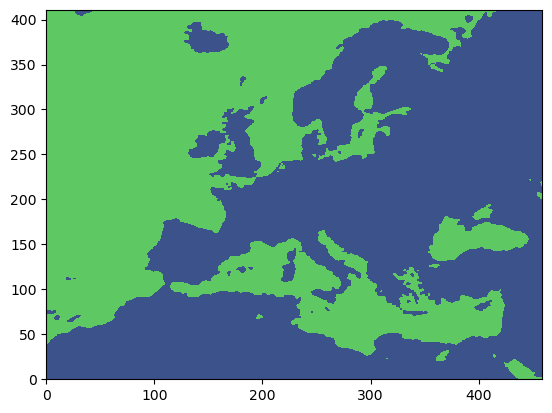

In [8]:
# Look at mask
plt.contourf(ds.orogf.values == 0)

In [9]:
# Mask out sea values
orogf = ds.orogf.values 
orogf[orogf == 0] = np.nan

#### Make a list of all cominations of rlon and rlat values

In [10]:
df = pd.DataFrame(columns = ['lon', 'lat', 'i', 'j'])
df

,lon,lat,i,j


In [11]:
counter = 0 
lons = []
lats = []
Is = []
Js = []

for i, lon in enumerate(ds.rlon.values):
    for j, lat in enumerate(ds.rlat.values):
        if np.isnan(orogf[j, i]) == False:
            lons.append(lon)
            lats.append(lat)
            Is.append(i)
            Js.append(j)


In [12]:
df['lon'] = lons
df['lat'] = lats
df['i'] = Is
df['j'] = Js

In [13]:
df

,lon,lat,i,j
0,-31.674988,-23.375000,0,0
1,-31.674988,-23.265001,0,1
2,-31.674988,-23.155001,0,2
3,-31.674988,-23.045000,0,3
4,-31.674988,-22.935001,0,4
...,...,...,...,...
105698,18.815002,21.395000,459,407
105699,18.815002,21.504999,459,408
105700,18.815002,21.615000,459,409
105701,18.815002,21.725000,459,410


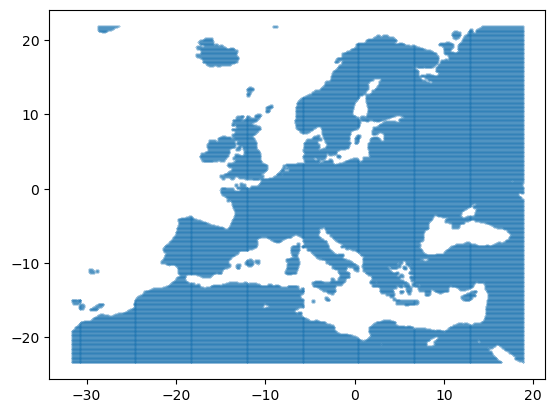

In [14]:
fig, ax = plt.subplots()
ax.plot(df.lon, df.lat,'.', ms = 0.4)

### 2. Open grid file

In [15]:
grid = gpd.read_file("O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/" + folder + "/grid/europe_10km_grid.shp")

In [16]:
grid.head()

,id,geometry
0,68467.0,"POLYGON ((4053879.27 2675289.001, 4063879.27 2..."
1,68468.0,"POLYGON ((4063494.246 2659010.778, 4062388.158..."
2,68474.0,"POLYGON ((4054706.808 2599863.56, 4058556.835 ..."
3,68475.0,"POLYGON ((4053879.27 2595289.001, 4063879.27 2..."
4,68476.0,"POLYGON ((4053879.27 2585289.001, 4063879.27 2..."


In [17]:
# Calculate centre and convert to EPSG-4326
grid['centre'] = grid.centroid.to_crs(4326)

#### Convert shapefile centroid to rotated coordinates

In [18]:
rotated_pole_lat = 39.25
rotated_pole_lon = 198.0

In [19]:
#Create a rotated pole projection based on the dataset's pole coordinates.
rotated_pole_proj = ccrs.RotatedPole(pole_latitude=rotated_pole_lat, pole_longitude=rotated_pole_lon)

#Use a standard geographic (PlateCarree) projection for lon/lat coordinates.
standard_projection = ccrs.PlateCarree()

In [20]:
rlons = []
rlats = []
for i, row in grid.iterrows():
    rlon, rlat = rotated_pole_proj.transform_point(row.centre.coords.xy[0][0], row.centre.coords.xy[1][0], standard_projection)
    rlons.append(rlon)
    rlats.append(rlat)

In [21]:
grid['rlon'] = rlons
grid['rlat'] = rlats

#### Check conversion makes sense

In [22]:
crs = ccrs.RotatedPole(pole_longitude=rotated_pole_lon, pole_latitude=rotated_pole_lat)

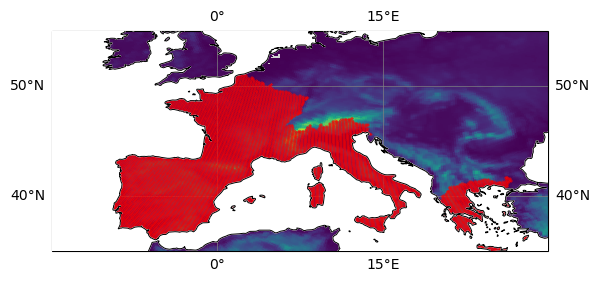

In [23]:
import cartopy
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

for axi in f.axes:
    axi.set_global()
    
    axi.set_extent([ -15, 30,35, 55], crs=ccrs.PlateCarree())
    
    axi.add_feature(cartopy.feature.OCEAN, color='white', zorder=30)
    axi.add_feature(cartopy.feature.LAND, color='lightgray',zorder=0,
                  linewidth=0.5, edgecolor='black')
    
    axi.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                xlocs=range(-15,45,15), ylocs=range(30,75,10), zorder = 50)
    
    axi.coastlines(resolution='50m', linewidth=0.7, color='black', zorder = 35)


crs = ccrs.RotatedPole(pole_longitude=198.0, pole_latitude=39.25)

ax.pcolormesh(ds.rlon, ds.rlat, ds.orogf, transform = crs)
ax.plot(grid.rlon, grid.rlat, 'r.', transform = crs, ms = 0.5 )

### 3. For each grid ID, find closest climex2 grid point and append i and j values

In [24]:
ind_lon = []
ind_lat = []
lons = []
lats = []
missed_ids= []
t0 = time.time()

for i, row in grid.iterrows():
    
    print(i)
    dists = []

    # ID for which to find closest climex2 point 
    lat_search = row.rlat
    lon_search = row.rlon

    # Create a searchbox to calculate distances in
    df_search = df[((df.lat > (lat_search -0.5)) & (df.lat < (lat_search + 0.5))) & ((df.lon > (lon_search -0.5)) & (df.lon < (lon_search + 0.5)))]
    df_search = df_search

    # Calculate distances
    for j, r in df_search.iterrows():
        dists.append(geopy.distance.geodesic((lat_search, lon_search), (df_search['lat'][j], df_search['lon'][j])).km)

    # Some points are not located within 0.5 degrees of the search lon lat (islands in the Med)
    try:
        arg = np.nanargmin(dists)
        arg = df_search.iloc[arg, :].name # need number of the big list not subsample
        ind_lon.append(df['i'][arg])
        ind_lat.append(df['j'][arg])
        lons.append(df['lon'][arg])
        lats.append(df['lat'][arg])
    except Exception as e: 
        print(e)
        missed_ids.append(int(row.id))
        ind_lon.append(np.nan)
        ind_lat.append(np.nan)
        lons.append(np.nan)
        lats.append(np.nan)
        
    clear_output(wait=True)
  
t1 = time.time()
print((t1-t0)/60)

9.071839066346486


In [25]:
missed_ids

[78261, 78262, 78481, 78482, 106636, 106854, 107735]

In [26]:
grid['i'] = ind_lon
grid['j'] = ind_lat
grid['lon'] = lons
grid['lat'] = lats

#### Check results for one time step

In [27]:
vals = []
t0 = time.time()
for i, row in grid.iterrows():
    try: 
        vals.append(ds.orogf.values[int(row.j), int(row.i)])
    except Exception as e: 
        vals.append(np.nan)
t1 = time.time()
print(t1 -t0)

2.1431357860565186


In [28]:
t0 = time.time()
js = list(grid.j)
Is = list(grid.i)

t1 = time.time()
print(t1 -t0)

0.005730152130126953


In [29]:
grid['vals'] = vals


In [30]:
grid_smp = grid.iloc[::10, ::].reset_index(drop=True)


(-15.0, 2.5)

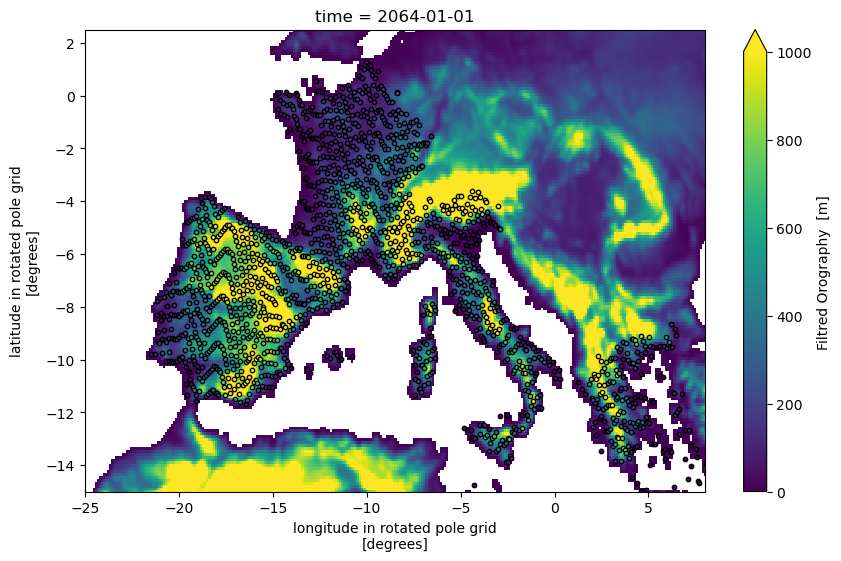

In [31]:
fig, ax = plt.subplots(figsize = (10, 6))
ds.orogf.plot(ax = ax, zorder = 0, vmin = 0, vmax = 1000)
for i, row in grid_smp.iterrows():
    print(i)
    ax.scatter(row.rlon, row.rlat, c = row.vals, s = 10, vmin = 0, vmax = 1000, edgecolor = 'k')
    clear_output(wait=True)
ax.set_xlim([-25, 8])
ax.set_ylim([-15, 2.5])

#### Remove nan values

In [32]:
grid = grid.dropna().reset_index(drop = True)

In [33]:
grid['i'] = grid.i.astype('int64')
grid['j'] = grid.j.astype('int64')

In [34]:
grid

,id,geometry,centre,rlon,rlat,i,j,lon,lat,vals
0,68467.0,"POLYGON ((4053879.27 2675289.001, 4063879.27 2...",POINT (6.54912 47.09123),-7.779252,-3.056448,217,185,-7.804993,-3.025001,823.5625
1,68468.0,"POLYGON ((4063494.246 2659010.778, 4062388.158...",POINT (6.55017 47.0125),-7.790681,-3.134347,217,184,-7.804993,-3.135000,936.1250
2,68474.0,"POLYGON ((4054706.808 2599863.56, 4058556.835 ...",POINT (6.58998 46.4361),-7.852440,-3.708092,217,179,-7.804993,-3.685000,585.5625
3,68475.0,"POLYGON ((4053879.27 2595289.001, 4063879.27 2...",POINT (6.59569 46.37177),-7.858436,-3.772264,217,178,-7.804993,-3.795001,855.1250
4,68476.0,"POLYGON ((4053879.27 2585289.001, 4063879.27 2...",POINT (6.6014 46.28182),-7.868365,-3.861759,216,177,-7.914993,-3.905000,1056.2500
...,...,...,...,...,...,...,...,...,...,...
17464,110366.0,"POLYGON ((5954048.339 1676431.673, 5954317.113...",POINT (28.23503 36.39192),8.468608,-13.772167,365,87,8.475006,-13.805000,27.0625
17465,110367.0,"MULTIPOLYGON (((5955063.479 1674029.759, 59546...",POINT (28.23108 36.37672),8.467587,-13.787662,365,87,8.475006,-13.805000,27.0625
17466,112786.0,"POLYGON ((6071543.557 1678322.901, 6070929.886...",POINT (29.49478 36.15433),9.539356,-13.854383,375,87,9.575012,-13.805000,330.6875
17467,113006.0,"MULTIPOLYGON (((6083832.405 1677528.343, 60838...",POINT (29.58453 36.14176),9.615116,-13.855233,375,87,9.575012,-13.805000,330.6875


### 4. Repeat for all time steps 


In [35]:
js = list(grid.j)
Is = list(grid.i)

In [36]:
ens = "hpp"
start_year = "1991"
end_year = "2010"

In [38]:
var = 'tas'
fname = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/CLIMEX2/debiased/"+ var + "/" + ens + "/" + var + "_" + start_year + "-" + end_year + "_QM.nc"
ds = xr.open_dataset(fname, chunks = {'rlat': 20, 'rlon': 20, 'time': 20})
import time
t0 = 0
t1 = 1
shp_new = grid.iloc[:, :15].copy()

t0 = time.time()
for t in range(len(ds.time)):

    vals = ds['tas'].isel(time = t).values[js, Is]
    try :
        shp_new[ds.time.values[t].strftime("%Y-%m-%d")] = vals
        print(ds.time.values[t].strftime("%Y-%m-%d"))
    except Exception as e:
        shp_new[ds.time.values[t].astype('str')[:10]] = vals
        print(ds.time.values[t].astype('str')[:10])
    tstep1 = time.time()

    clear_output(wait=True)

t1 = time.time()
print((t1 -t0)/60)
shp_new.to_csv(save_path + '/' + var + "_" + start_year + "-" + end_year + "_" + ens +  "_QM.csv")

KeyboardInterrupt: 

In [ ]:
var = 'pr'
fname = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/CLIMEX2/debiased/"+ var + "/" + ens + "/" + var + "_" + start_year + "-" + end_year +"_QM.nc"
ds = xr.open_dataset(fname, chunks = {'rlat': 20, 'rlon': 20, 'time': 20})
import time
t0 = 0
t1 = 1
shp_new = grid.iloc[:, :15].copy()

t0 = time.time()
for t in range(len(ds.time)):

    vals = ds[var].isel(time = t).values[js, Is]
    try :
        shp_new[ds.time.values[t].strftime("%Y-%m-%d")] = vals
        print(ds.time.values[t].strftime("%Y-%m-%d"))
    except Exception as e:
        shp_new[ds.time.values[t].astype('str')[:10]] = vals
        print(ds.time.values[t].astype('str')[:10])
    tstep1 = time.time()

    clear_output(wait=True)

shp_new.to_csv(save_path + '/'+ var + "_" + start_year + "-" + end_year + "_" + ens +"_climex_QM.csv")


t1 = time.time()
print((t1 -t0)/60)

In [ ]:
var = 'hurs'
fname = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/CLIMEX2/debiased/"+ var + "/" + ens + "/" + var + "_" + start_year + "-" + end_year +"_LS.nc"
ds = xr.open_dataset(fname, chunks = {'rlat': 20, 'rlon': 20, 'time': 20})
import time
t0 = 0
t1 = 1
shp_new = grid.iloc[:, :15].copy()

t0 = time.time()
for t in range(len(ds.time)):

    vals = ds['rhum'].isel(time = t).values[js, Is]
    try :
        shp_new[ds.time.values[t].strftime("%Y-%m-%d")] = vals
        print(ds.time.values[t].strftime("%Y-%m-%d"))
    except Exception as e:
        shp_new[ds.time.values[t].astype('str')[:10]] = vals
        print(ds.time.values[t].astype('str')[:10])
    tstep1 = time.time()

    clear_output(wait=True)

shp_new.to_csv(save_path + '/' + var + "_" + start_year + "-" + end_year+ "_" + ens  +"_climex_LS.csv")


t1 = time.time()
print((t1 -t0)/60)

In [ ]:
var = 'wind'
fname = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/CLIMEX2/debiased/"+ var + "/" + ens + "/" + var + "_" + start_year + "-" + end_year +"_LS.nc"
ds = xr.open_dataset(fname, chunks = {'rlat': 20, 'rlon': 20, 'time': 20})
import time
t0 = 0
t1 = 1
shp_new = grid.iloc[:, :15].copy()

t0 = time.time()
for t in range(len(ds.time)):

    vals = ds[var].isel(time = t).values[js, Is]
    try :
        shp_new[ds.time.values[t].strftime("%Y-%m-%d")] = vals
        print(ds.time.values[t].strftime("%Y-%m-%d"))
    except Exception as e:
        shp_new[ds.time.values[t].astype('str')[:10]] = vals
        print(ds.time.values[t].astype('str')[:10])
    tstep1 = time.time()

    clear_output(wait=True)


shp_new.to_csv(save_path + '/' + var + "_" + start_year + "-" + end_year + "_" + ens +"_climex_LS.csv")

t1 = time.time()
print((t1 -t0)/60)
        

In [ ]:
exit()